# BMED 6780 Programming Practical II

## Deep Classifier and Performance Metrics: MedNIST

### a1. Load the Data: Display 10 random images with their associated labels


In [18]:
import numpy as np
import os
from matplotlib import pyplot as plt
import imageio.v2 as imageio
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from PIL import Image

!pip uninstall torchvision

In [3]:
pwd

'C:\\Users\\sinad\\OneDrive - Georgia Institute of Technology\\BMED 6780 - Med Image Processing\\Programming Practicals\\Practical 2\\Practical_2'

In [4]:
cd ..

C:\Users\sinad\OneDrive - Georgia Institute of Technology\BMED 6780 - Med Image Processing\Programming Practicals\Practical 2


In [5]:
# Load the data:
directory = 'C:\\Users\\sinad\\OneDrive - Georgia Institute of Technology\\BMED 6780 - Med Image Processing\\Programming Practicals\\Practical 2\\MedNIST'
dir_path = os.path.abspath(directory)
print("The MedNIST path is: ", dir_path)

The MedNIST path is:  C:\Users\sinad\OneDrive - Georgia Institute of Technology\BMED 6780 - Med Image Processing\Programming Practicals\Practical 2\MedNIST


In [6]:
# List to store image file paths
image_files = []

# List to store labels
labels = []

# Loop through subfolders
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.endswith('.jpeg') or file.endswith('.jpg') or file.endswith('.png'):
            image_files.append(os.path.join(root, file))
            labels.append(os.path.basename(root))

# Print the number of image files and labels
print("Number of image files:", len(image_files))
print("Number of labels:", len(labels))

Number of image files: 58954
Number of labels: 58954


In [7]:
print(image_files[0:1])

['C:\\Users\\sinad\\OneDrive - Georgia Institute of Technology\\BMED 6780 - Med Image Processing\\Programming Practicals\\Practical 2\\MedNIST\\AbdomenCT\\000000.jpeg']


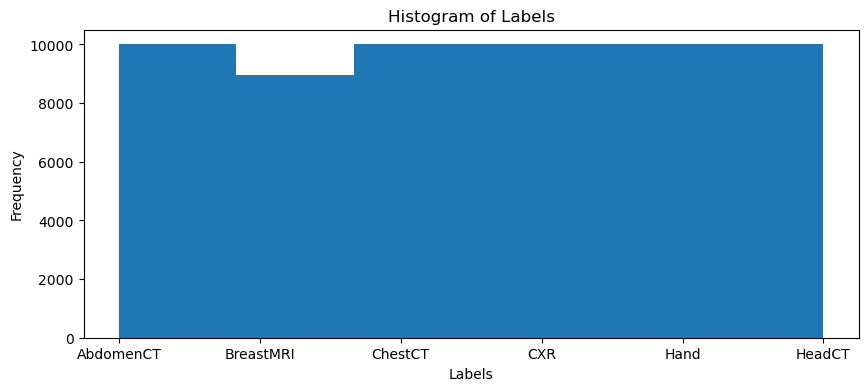

In [8]:
# Plot histogram of labels
plt.figure(figsize=(10, 4))
plt.hist(labels, bins=6)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Histogram of Labels')
plt.show()

In [9]:
# Check for imbalance
unique_labels = set(labels)
label_counts = {label: labels.count(label) for label in unique_labels}
print("Label Counts:", label_counts)

Label Counts: {'AbdomenCT': 10000, 'ChestCT': 10000, 'Hand': 10000, 'HeadCT': 10000, 'BreastMRI': 8954, 'CXR': 10000}


000000.jpeg
000000.jpeg
000000.jpeg
000000.jpeg
000000.jpeg
000000.jpeg


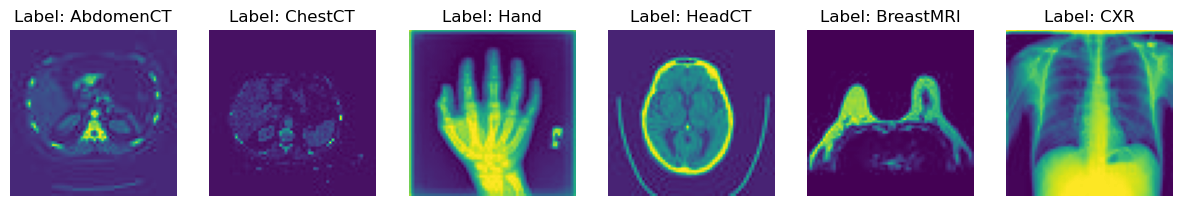

In [10]:
# Display an image from each label
plt.figure(figsize=(15, 10))
for i, label in enumerate(unique_labels):
    plt.subplot(1, 6, i+1)
    image_path = os.path.join(dir_path, [filename for filename in image_files if label in filename][0])
    print(image_path.split(sep="\\")[-1])
    img = imageio.imread(image_path)
    plt.imshow(img)
    plt.title('Label: ' + label)
    plt.axis('off')
plt.show()

### a.2 We need to convert the JPEG images into tensors to resize every image to the range of [0 to 1] by dividing the maximumimage intensity value.
### a.3: After rescaling, please randomly split the dataset into train, validation and test set with a reasonable split ratio (e.g., train:validation:test=7:2:1).

In [16]:
batch_size = 16
learning_rate = 1e-3

In [20]:
# Assuming you have a custom dataset class named MyDataset
class MyDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load and preprocess your image here
        image_path = self.image_files[idx]
        label = self.labels[idx]
        
        # Open image using PIL
        with Image.open(image_path) as img:
            # Convert image to grayscale if it has multiple channels
            if img.mode != 'L':
                img = img.convert('L')
            
            # Apply transformations if provided
            if self.transform:
                img = self.transform(img)
            
            # Convert image to tensor and normalize pixel intensities to [0, 1]
            img = torch.tensor(img, dtype=torch.float32) / 255.0
        
        return img, label

# Create a dataset instance
dataset = MyDataset(image_files, labels)

# Define the sizes of train, validation, and test sets
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

# Use random_split to split the dataset
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoader instances for each split
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print("Number of training samples:", len(train_set))
print("Number of validation samples:", len(val_set))
print("Number of test samples:", len(test_set))


Number of training samples: 41267
Number of validation samples: 11790
Number of test samples: 5897


### b. A convolutional neural network (CNN) that contains 2 convolutional layers. The architecture of this model is: [INPUT - CONV - RELU - MAXPOOL - CONV - RELU - MAXPOOL - FC1 - FC2 - FC3]

In [23]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # 7x7 is the spatial dimension after 2 maxpooling layers
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = self.fc1(x)
        x = self.relu(x)  # ReLU activation for the first fully connected layer
        x = self.fc2(x)
        x = self.relu(x)  # ReLU activation for the second fully connected layer
        x = self.fc3(x)
        return x


In [26]:
model = SimpleCNN(num_classes=6)
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=6, bias=True)
)
